<a href="https://colab.research.google.com/github/dsmlraghu/Cover_simulation/blob/main/Torsional_spring_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter shape (R=Rectangular / S=Square / T=Triangular): S
Enter Length (mm): 800
Enter Breadth (mm) — Enter 0 if square: 1200
Enter Weight of the cover (kg): 80
Enter Inner Diameter of spring (mm) [shaft diameter]: 24
Enter Wire Diameter (mm): 9
Enter Material Density (kg/m³) [default 7850]: 7850
Enter Modulus of Elasticity (MPa) [default 200000]: 196000
Enter Poisson's ratio [default 0.3]: 0.28
Enter Admissible Stress (MPa) [default 690]: 300

--- SPRING DESIGN RESULTS (Each of 2 Springs) ---


,Spring Parameters
Torque per Spring (Nm),98.1
Torque with SF (Nm),147.15
Wire Diameter (mm),9.0
Inner Diameter (mm),24.0
Outer Diameter (mm),42.0
Mean Coil Diameter (mm),33.0
Number of Coils,5
Modulus of Elasticity (MPa),196000.0
Modulus of Rigidity (MPa),76562.5
Spring Length (mm),45.0



--- TORQUE and STRESS vs ANGLE ---


,Angle (deg),Torque (Nm),Stress (MPa)
0,0.000000,0.000000,0.000000
1,1.530612,7.530451,3.472222
2,3.061224,15.060902,6.944444
3,4.591837,22.591353,10.416667
4,6.122449,30.121805,13.888889


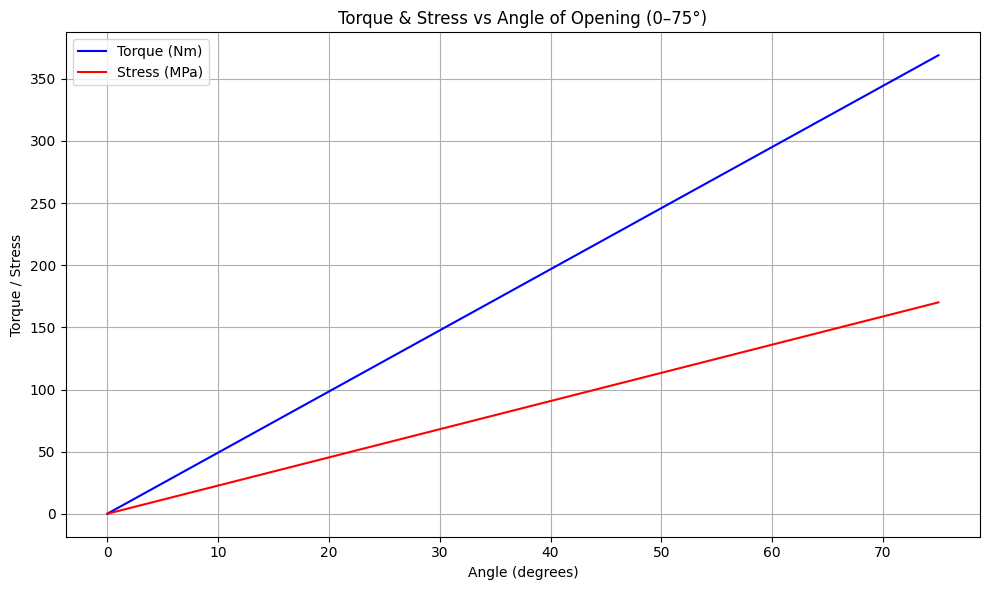


✅ Excel file saved as 'spring_design_output.xlsx'
Spring mounting diagram not found.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

# === USER INPUT ===
shape_input = input("Enter shape (R=Rectangular / S=Square / T=Triangular): ").strip().upper()
shape_map = {'R': 'rectangular', 'S': 'square', 'T': 'triangular'}
shape = shape_map.get(shape_input)
if not shape:
    raise ValueError("Invalid shape selection. Use R, S, or T.")

length_mm = float(input("Enter Length (mm): "))
breadth_mm = float(input("Enter Breadth (mm) — Enter 0 if square: "))
weight_kg = float(input("Enter Weight of the cover (kg): "))
weight_N = weight_kg * 9.81

inner_diameter_mm = float(input("Enter Inner Diameter of spring (mm) [shaft diameter]: "))
wire_diameter_mm = float(input("Enter Wire Diameter (mm): "))

density = float(input("Enter Material Density (kg/m³) [default 7850]: ") or 7850)
E_input = float(input("Enter Modulus of Elasticity (MPa) [default 200000]: ") or 200000)
poisson_ratio = float(input("Enter Poisson's ratio [default 0.3]: ") or 0.3)
admissible_stress = float(input("Enter Admissible Stress (MPa) [default 690]: ") or 690)

# === UNIT CONVERSIONS ===
E = E_input * 1e6
G = E / (2 * (1 + poisson_ratio))
ID = inner_diameter_mm / 1000
d_wire = wire_diameter_mm / 1000
OD = ID + 2 * d_wire
D_mean = ID + d_wire

# === SPRING DESIGN FUNCTION ===
def design_spring_iterative(shape, length_mm, breadth_mm, weight_N, density, G, admissible_stress, D_mean, d_wire, ID, OD):
    lever_arm = 0.25  # assumed horizontal distance from hinge to CG
    total_torque = weight_N * lever_arm
    torque = total_torque / 2  # each spring shares half the torque
    torque_safe = torque * 1.5  # apply safety factor

    n_coils = 5
    stress = float('inf')
    warning_msgs = []

    while stress > admissible_stress * 1e6:
        k = (G * d_wire**4) / (10.8 * D_mean * n_coils)
        stress = (32 * torque_safe * D_mean) / (np.pi * d_wire**3)

        if n_coils > 50:
            warning_msgs.append("❌ Number of coils exceeded 50.")
            break

        if stress > admissible_stress * 1e6:
            n_coils += 1

    deflection_rad = torque_safe / k
    deflection_deg = np.degrees(deflection_rad)
    energy = 0.5 * torque_safe * deflection_rad

    angles_rad = np.linspace(0, np.radians(75), 50)
    torques = k * angles_rad
    stresses = (32 * torques * D_mean) / (np.pi * d_wire**3) / 1e6  # MPa

    result = {
        "Torque per Spring (Nm)": torque,
        "Torque with SF (Nm)": torque_safe,
        "Wire Diameter (mm)": d_wire * 1000,
        "Inner Diameter (mm)": ID * 1000,
        "Outer Diameter (mm)": OD * 1000,
        "Mean Coil Diameter (mm)": D_mean * 1000,
        "Number of Coils": n_coils,
        "Modulus of Elasticity (MPa)": E / 1e6,
        "Modulus of Rigidity (MPa)": G / 1e6,
        "Spring Length (mm)": n_coils * d_wire * 1000,
        "Stress (MPa)": stress / 1e6,
        "Stress OK?": "Yes" if stress <= admissible_stress * 1e6 else "No",
        "Angular Deflection (rad)": deflection_rad,
        "Angular Deflection (deg)": deflection_deg,
        "Spring Stiffness (Nm/rad)": k,
        "Energy Stored (J)": energy
    }

    df_result = pd.DataFrame(result, index=["Spring Parameters"])
    df_curve = pd.DataFrame({
        "Angle (deg)": np.degrees(angles_rad),
        "Torque (Nm)": torques,
        "Stress (MPa)": stresses
    })

    return df_result, df_curve, warning_msgs

# === RUN DESIGN ===
df_result, df_curve, warnings = design_spring_iterative(
    shape, length_mm, breadth_mm, weight_N, density, G, admissible_stress, D_mean, d_wire, ID, OD
)

# === DISPLAY RESULTS ===
print("\n--- SPRING DESIGN RESULTS (Each of 2 Springs) ---")
display(df_result.T)

print("\n--- TORQUE and STRESS vs ANGLE ---")
display(df_curve.head())

# === PLOT RESULTS ===
plt.figure(figsize=(10, 6))
plt.plot(df_curve["Angle (deg)"], df_curve["Torque (Nm)"], label="Torque (Nm)", color='blue')
plt.plot(df_curve["Angle (deg)"], df_curve["Stress (MPa)"], label="Stress (MPa)", color='red')
plt.title("Torque & Stress vs Angle of Opening (0–75°)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Torque / Stress")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("spring_chart.png", dpi=300)
plt.show()

# === EXPORT TO EXCEL ===
filename = "spring_design_output.xlsx"
with pd.ExcelWriter(filename) as writer:
    df_result.T.to_excel(writer, sheet_name="Spring Design Summary", index=True)
    df_curve.to_excel(writer, sheet_name="Torque and Stress Curve", index=False)

print(f"\n✅ Excel file saved as '{filename}'")

# === DISPLAY SPRING DIAGRAM ===
try:
    img_path = "/mnt/data/A_technical_illustration_in_digital_medium_depicts.png"
    img = Image.open(img_path)
    print("\n--- SPRING MOUNTING DIAGRAM ---")
    display(img)
except Exception as e:
    print("Spring mounting diagram not found.")


Enter shape (R=Rectangular / S=Square / T=Triangular): T
Enter Length (mm): 1200
Enter Breadth (mm) — Enter 0 if square: 2000
Enter Weight of the cover (kg): 102
Enter Inner Diameter of spring (mm) [shaft diameter]: 24
Enter Spring Arm (leg) Length (mm) [default 30]: 85
Enter Lever Arm distance from hinge to CG (mm) [default 250]: 250
Enter Material Density (kg/m³) [default 7850]: 7850
Enter Modulus of Elasticity (MPa) [default 200000]: 196000
Enter Poisson's ratio [default 0.3]: 0.28
Enter Admissible Stress (MPa) [default 690]: 500

--- SPRING DESIGN RESULTS (Each of 2 Springs) ---


,Spring Parameters
Torque per Spring (Nm),125.0775
Torque with SF (Nm),187.61625
Wire Diameter (mm),6.0
Inner Diameter (mm),24.0
Mean Coil Diameter (mm),30.0
Outer Diameter (mm),36.0
Number of Coils,2.0
Modulus of Elasticity (MPa),196000.0
Modulus of Rigidity (MPa),76562.5
Spring Coil Length (mm),12.0



--- TORQUE and STRESS vs ANGLE ---


,Angle (deg),Torque (Nm),Stress (MPa)
0,0.000000,0.000000,0.000000
1,1.530612,4.090615,5.787037
2,3.061224,8.181231,11.574074
3,4.591837,12.271846,17.361111
4,6.122449,16.362462,23.148148


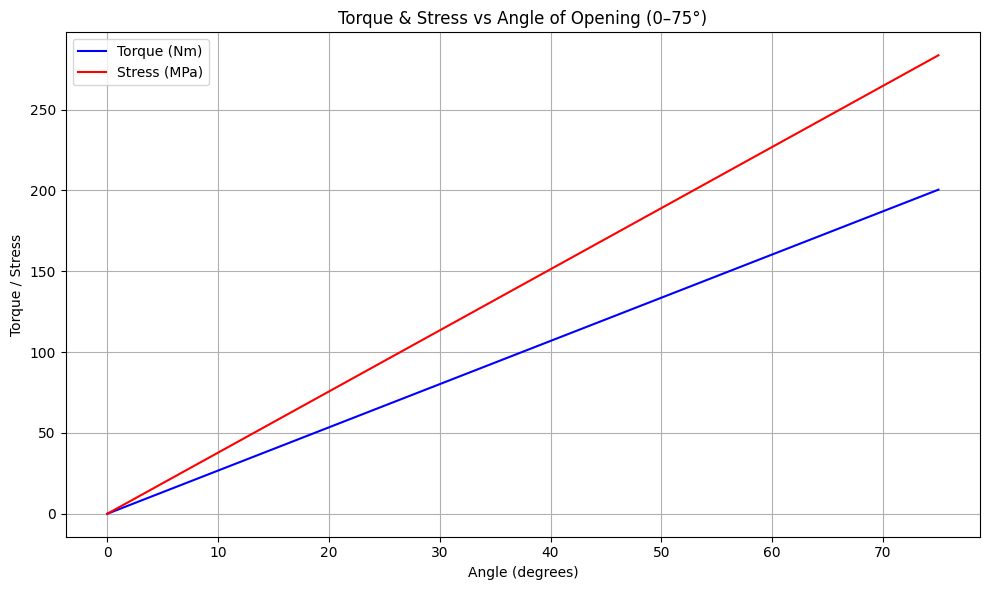


✅ Excel file saved as 'spring_design_output.xlsx'


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === USER INPUT ===
shape_input = input("Enter shape (R=Rectangular / S=Square / T=Triangular): ").strip().upper()
shape_map = {'R': 'rectangular', 'S': 'square', 'T': 'triangular'}
shape = shape_map.get(shape_input)
if not shape:
    raise ValueError("Invalid shape selection. Use R, S, or T.")

length_mm = float(input("Enter Length (mm): "))
breadth_mm = float(input("Enter Breadth (mm) — Enter 0 if square: "))
weight_kg = float(input("Enter Weight of the cover (kg): "))
weight_N = weight_kg * 9.81

inner_diameter_mm = float(input("Enter Inner Diameter of spring (mm) [shaft diameter]: "))
spring_arm_mm = float(input("Enter Spring Arm (leg) Length (mm) [default 30]: ") or 30)
lever_arm_mm = float(input("Enter Lever Arm distance from hinge to CG (mm) [default 250]: ") or 250)
lever_arm = lever_arm_mm / 1000

density = float(input("Enter Material Density (kg/m³) [default 7850]: ") or 7850)
E_input = float(input("Enter Modulus of Elasticity (MPa) [default 200000]: ") or 200000)
poisson_ratio = float(input("Enter Poisson's ratio [default 0.3]: ") or 0.3)
admissible_stress = float(input("Enter Admissible Stress (MPa) [default 690]: ") or 690)

# === UNIT CONVERSIONS ===
E = E_input * 1e6
G = E / (2 * (1 + poisson_ratio))
ID = inner_diameter_mm / 1000
spring_arm = spring_arm_mm / 1000

# === SPRING DESIGN FUNCTION ===
def design_spring_iterative(shape, length_mm, breadth_mm, weight_N, density, G, admissible_stress, ID, spring_arm):
    total_torque = weight_N * lever_arm  # from total weight and CG distance
    torque = total_torque / 2            # per spring
    torque_safe = torque * 1.5           # with safety factor

    for d_wire_mm in np.arange(6, 9.1, 0.5):  # wire diameter from 6 to 9 mm
        d_wire = d_wire_mm / 1000
        D_mean = ID + d_wire
        for n_coils in np.arange(2, 6.6, 0.1):  # coils from 2 to 6.5
            k = (G * d_wire**4) / (10.8 * D_mean * n_coils)
            stress = (32 * torque_safe * D_mean) / (np.pi * d_wire**3)
            if stress <= admissible_stress * 1e6:
                deflection_rad = torque_safe / k
                deflection_deg = np.degrees(deflection_rad)
                energy = 0.5 * torque_safe * deflection_rad
                angles_rad = np.linspace(0, np.radians(75), 50)
                torques = k * angles_rad
                stresses = (32 * torques * D_mean) / (np.pi * d_wire**3) / 1e6

                result = {
                    "Torque per Spring (Nm)": torque,
                    "Torque with SF (Nm)": torque_safe,
                    "Wire Diameter (mm)": d_wire_mm,
                    "Inner Diameter (mm)": ID * 1000,
                    "Mean Coil Diameter (mm)": D_mean * 1000,
                    "Outer Diameter (mm)": (D_mean + d_wire) * 1000,
                    "Number of Coils": round(n_coils, 2),
                    "Modulus of Elasticity (MPa)": E / 1e6,
                    "Modulus of Rigidity (MPa)": G / 1e6,
                    "Spring Coil Length (mm)": n_coils * d_wire * 1000,
                    "Spring Arm Length (mm)": spring_arm * 1000,
                    "Total Lever Length (mm)": spring_arm * 1000 + (D_mean * 1000 / 2),
                    "Stress (MPa)": stress / 1e6,
                    "Stress OK?": "Yes",
                    "Angular Deflection (rad)": deflection_rad,
                    "Angular Deflection (deg)": deflection_deg,
                    "Spring Stiffness (Nm/rad)": k,
                    "Energy Stored (J)": energy,
                    "Lever Arm (mm)": lever_arm * 1000
                }

                df_result = pd.DataFrame(result, index=["Spring Parameters"])
                df_curve = pd.DataFrame({
                    "Angle (deg)": np.degrees(angles_rad),
                    "Torque (Nm)": torques,
                    "Stress (MPa)": stresses
                })

                return df_result, df_curve, []

    return None, None, ["❌ No valid spring configuration found within given limits."]

# === RUN DESIGN ===
df_result, df_curve, warnings = design_spring_iterative(
    shape, length_mm, breadth_mm, weight_N, density, G, admissible_stress, ID, spring_arm
)

# === DISPLAY RESULTS ===
if df_result is not None:
    print("\n--- SPRING DESIGN RESULTS (Each of 2 Springs) ---")
    display(df_result.T)

    print("\n--- TORQUE and STRESS vs ANGLE ---")
    display(df_curve.head())

    # === PLOT RESULTS ===
    plt.figure(figsize=(10, 6))
    plt.plot(df_curve["Angle (deg)"], df_curve["Torque (Nm)"], label="Torque (Nm)", color='blue')
    plt.plot(df_curve["Angle (deg)"], df_curve["Stress (MPa)"], label="Stress (MPa)", color='red')
    plt.title("Torque & Stress vs Angle of Opening (0–75°)")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Torque / Stress")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("spring_chart.png", dpi=300)
    plt.show()

    # === EXPORT TO EXCEL ===
    filename = "spring_design_output.xlsx"
    with pd.ExcelWriter(filename) as writer:
        df_result.T.to_excel(writer, sheet_name="Spring Design Summary", index=True)
        df_curve.to_excel(writer, sheet_name="Torque and Stress Curve", index=False)

    print(f"\n✅ Excel file saved as '{filename}'")

else:
    print("\n".join(warnings))


Enter shape (R=Rectangular / S=Square / T=Triangular): R
Enter Length (mm): 600
Enter Breadth (mm) — Enter 0 if square: 700
Enter Weight of the cover (kg): 80
Enter Inner Diameter of spring (mm) [shaft diameter]: 24
Enter Spring Arm (leg) Length (mm) [default 30]: 80
Enter Material Density (kg/m³) [default 7850]: 7850
Enter Modulus of Elasticity (MPa) [default 200000]: 193000
Enter Poisson's ratio [default 0.3]: 0.28
Enter Admissible Stress (MPa) [default 690]: 590

--- SPRING DESIGN RESULTS ---

                               Spring Parameters
Torque per Spring (Nm)                 30.468178
Torque with SF (Nm)                    45.702267
Wire Diameter (mm)                           6.0
Inner Diameter (mm)                         24.0
Mean Coil Diameter (mm)                     30.0
Outer Diameter (mm)                         36.0
Number of Coils                              2.0
Modulus of Elasticity (MPa)             193000.0
Modulus of Rigidity (MPa)              75390.625
Spring C

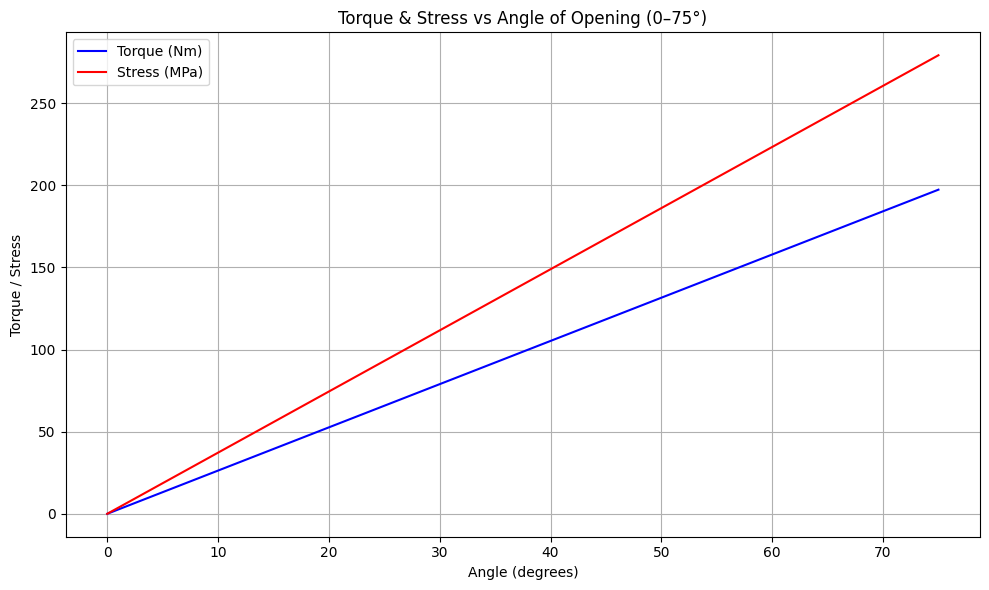


✅ Excel saved: spring_design_output_final.xlsx


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === USER INPUT ===
shape_input = input("Enter shape (R=Rectangular / S=Square / T=Triangular): ").strip().upper()
shape_map = {'R': 'rectangular', 'S': 'square', 'T': 'triangular'}
shape = shape_map.get(shape_input)
if not shape:
    raise ValueError("Invalid shape selection. Use R, S, or T.")

length_mm = float(input("Enter Length (mm): "))
breadth_mm = float(input("Enter Breadth (mm) — Enter 0 if square: "))
weight_kg = float(input("Enter Weight of the cover (kg): "))
weight_N = weight_kg * 9.81

inner_diameter_mm = float(input("Enter Inner Diameter of spring (mm) [shaft diameter]: "))
spring_arm_mm = float(input("Enter Spring Arm (leg) Length (mm) [default 30]: ") or 30)

density = float(input("Enter Material Density (kg/m³) [default 7850]: ") or 7850)
E_input = float(input("Enter Modulus of Elasticity (MPa) [default 200000]: ") or 200000)
poisson_ratio = float(input("Enter Poisson's ratio [default 0.3]: ") or 0.3)
admissible_stress = float(input("Enter Admissible Stress (MPa) [default 690]: ") or 690)

# === UNIT CONVERSIONS ===
E = E_input * 1e6
G = E / (2 * (1 + poisson_ratio))
ID = inner_diameter_mm / 1000
spring_arm = spring_arm_mm / 1000
theta_rad = np.radians(75)

# === AUTO CALCULATE CG DISTANCE & LEVER ARM ===
if shape == "rectangular":
    cg_distance = (length_mm / 2) / 1000
elif shape == "square":
    cg_distance = (length_mm / 2) / 1000
elif shape == "triangular":
    cg_distance = (1/3) * (length_mm / 1000)
else:
    cg_distance = 0.25

lever_arm = cg_distance * np.cos(theta_rad)

# === SPRING DESIGN FUNCTION ===
def design_spring_iterative(weight_N, G, admissible_stress, ID, spring_arm, lever_arm):
    total_torque = weight_N * lever_arm
    torque = total_torque / 2
    torque_safe = torque * 1.5

    for d_wire_mm in np.arange(6, 9.1, 0.5):
        d_wire = d_wire_mm / 1000
        D_mean = ID + d_wire
        for n_coils in np.arange(2, 6.6, 0.1):
            k = (G * d_wire**4) / (10.8 * D_mean * n_coils)
            stress = (32 * torque_safe * D_mean) / (np.pi * d_wire**3)
            if stress <= admissible_stress * 1e6:
                deflection_rad = torque_safe / k
                deflection_deg = np.degrees(deflection_rad)
                energy = 0.5 * torque_safe * deflection_rad
                angles_rad = np.linspace(0, np.radians(75), 50)
                torques = k * angles_rad
                stresses = (32 * torques * D_mean) / (np.pi * d_wire**3) / 1e6

                result = {
                    "Torque per Spring (Nm)": torque,
                    "Torque with SF (Nm)": torque_safe,
                    "Wire Diameter (mm)": d_wire_mm,
                    "Inner Diameter (mm)": ID * 1000,
                    "Mean Coil Diameter (mm)": D_mean * 1000,
                    "Outer Diameter (mm)": (D_mean + d_wire) * 1000,
                    "Number of Coils": round(n_coils, 2),
                    "Modulus of Elasticity (MPa)": E / 1e6,
                    "Modulus of Rigidity (MPa)": G / 1e6,
                    "Spring Coil Length (mm)": n_coils * d_wire * 1000,
                    "Spring Arm Length (mm)": spring_arm * 1000,
                    "Total Lever Length (mm)": spring_arm * 1000 + (D_mean * 1000 / 2),
                    "Stress (MPa)": stress / 1e6,
                    "Stress OK?": "Yes",
                    "Angular Deflection (rad)": deflection_rad,
                    "Angular Deflection (deg)": deflection_deg,
                    "Spring Stiffness (Nm/rad)": k,
                    "Energy Stored (J)": energy,
                    "Auto-Calculated Lever Arm (mm)": lever_arm * 1000
                }

                df_result = pd.DataFrame(result, index=["Spring Parameters"])
                df_curve = pd.DataFrame({
                    "Angle (deg)": np.degrees(angles_rad),
                    "Torque (Nm)": torques,
                    "Stress (MPa)": stresses
                })

                return df_result, df_curve, []

    return None, None, ["❌ No valid spring configuration found within given limits."]

# === RUN DESIGN ===
df_result, df_curve, warnings = design_spring_iterative(
    weight_N, G, admissible_stress, ID, spring_arm, lever_arm
)

# === DISPLAY & EXPORT ===
if df_result is not None:
    print("\n--- SPRING DESIGN RESULTS ---\n")
    print(df_result.T)

    # Save Excel
    filename = "spring_design_output_final.xlsx"
    with pd.ExcelWriter(filename) as writer:
        df_result.T.to_excel(writer, sheet_name="Spring Design Summary", index=True)
        df_curve.to_excel(writer, sheet_name="Torque and Stress Curve", index=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_curve["Angle (deg)"], df_curve["Torque (Nm)"], label="Torque (Nm)", color='blue')
    plt.plot(df_curve["Angle (deg)"], df_curve["Stress (MPa)"], label="Stress (MPa)", color='red')
    plt.title("Torque & Stress vs Angle of Opening (0–75°)")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Torque / Stress")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("spring_chart_final.png", dpi=300)
    plt.show()

    print(f"\n✅ Excel saved: {filename}")
else:
    print("\n".join(warnings))
